# Import Packages

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, random_split, Dataset, Subset
# from torchtext import data
# from torchvision import transforms, models
from torchmetrics import Accuracy
import pytorch_lightning as pl
from pytorch_lightning.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import wandb
import torchmetrics
import sys
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray import tune
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
import numpy as np

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 지정된 프로시저를 찾을 수 없습니다
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaydenpark\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaydenpark\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Initialize weight and bias to logging

In [3]:
wandb.init(
      mode='disabled',
      # Set the project where this run will be logged
      project="disaster_tweet_classification", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"Test7", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.000003,
      "data_size": 1,
      "batch_size":32,
        "model_name":"distilbert-base-uncased" #"cardiffnlp/twitter-xlm-roberta-base-sentiment" # 
      })
wandb_logger = WandbLogger()

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\pytorch_lightning\loggers\wandb.py:347: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


# Lightning moduel
It is class to struct forward and backward propagation.  
I initially download pre-trained model from huggingface and used it as model in Lightning module to perform forward.  

In [4]:
class textClassifier(pl.LightningModule):
    def __init__(self, vocab_size=10_000, learning_rate=3e-4):
        super().__init__()
        self.save_hyperparameters()
        print(self.hparams)
        self.accuracy = Accuracy(task='binary')
        self.config = AutoConfig.from_pretrained(wandb.config['model_name'])
        self.config.num_labels = 1
        self.hugging_face_model = AutoModelForSequenceClassification.from_config(self.config)
    
    def forward(self, **inputs):
        return self.hugging_face_model(**inputs)
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(**batch)
    
    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        logits = outputs[1]
        pred = logits.squeeze()
        labels = batch['labels'].flatten().to(torch.int64)
        acc = self.accuracy(pred, labels)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_epoch=True, prog_bar=True)
        
        return {'loss':loss, 'pred':pred}
        
    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        logits = outputs[1]
        pred = logits.squeeze()
        labels = batch['labels'].flatten().to(torch.int64)
        acc = self.accuracy(pred, labels)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        
        return {'val_loss':loss, 'pred':pred}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adamax(self.parameters(), lr=self.hparams.learning_rate)
        return [optimizer]    

# Dataset
In the Dataset module, I preprocessed and vectorized tweets.  

In [5]:
import contractions
from bs4 import BeautifulSoup
from unidecode import unidecode
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

class textDataset(Dataset):
    def __init__(self, data_dir):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.tweets = pd.read_csv(data_dir)
        self.tweets['keyword'] = self.tweets['keyword'].fillna('')
        self.tweets['tweet'] = self.tweets['keyword'] + ' ' + self.tweets['text']
        self.tweets = self.text_preprocessing(self.tweets)
        self.tokenizer = AutoTokenizer.from_pretrained(wandb.config['model_name'])
    
    def rem_urls(self, data):
        regex = re.compile(f"https?://(www\.)?(\w+)(\.\w+)(/\w*)?")
        data = re.sub(regex, "", data)
        return data
    
    def rem_emails(self, data):
        regex = re.compile("([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+")
        data = re.sub(regex, "", data)
        return data
    
    def rem_mention(self, data):
        regex = re.compile('@\w+')
        data = re.sub(regex, '', data)
        return data
    
    def rem_accent(self, data):
        data = unidecode(data)
        return data
    
    def rem_unicode(self, data):
        data = data.encode("ascii", "ignore").decode()
        return data
    
    def rem_punc(self, data):
        data = re.sub(f"[{string.punctuation}]", " ", data)
        return data
    
    def clean_numbers(self, data):
        data = re.sub('[0-9]{5,}', '#'*5, data)
        data = re.sub('[0-9]{4}', '#'*4, data)
        data = re.sub('[0-9]{3}', '#'*3, data)
        data = re.sub('[0-9]{2}', '#'*2, data)
        return data
    
    
    def rem_stopwords(self, data):
        return " ".join([word for word in str(data).split() if word not in self.stop_words])
    
    def rem_extra_space(self, data):
        data = re.sub(' +', ' ', data).strip()
        return data
    
    
    def lemmatize_data(self, data):
        words = [self.lemmatizer.lemmatize(word) for word in data.split()]
        data = ' '.join(words)
        return data
    
    def text_preprocessing(self, data):
        data['tweet'] = data['tweet'].str.lower()
        data['tweet'] = data['tweet'].apply(contractions.fix)
        data['tweet'] = data['tweet'].apply(self.rem_urls)
        data['tweet'] = data['tweet'].apply(self.rem_emails)
        data['tweet'] = data['tweet'].apply(lambda x: BeautifulSoup(x).get_text())
        data['tweet'] = data['tweet'].apply(self.rem_mention)
        data['tweet'] = data['tweet'].str.replace(':\(', 'sadness ')
        data['tweet'] = data['tweet'].str.replace(r':\)[$|\s]*', 'happiness ')
        data['tweet'] = data['tweet'].str.replace(r'\;\)[$|\s]*', 'happiness ')
        data['tweet'] = data['tweet'].apply(self.rem_accent)
        data['tweet'] = data['tweet'].apply(self.rem_unicode)
        data['tweet'] = data['tweet'].apply(self.rem_punc)
        data['tweet'] = data['tweet'].apply(self.clean_numbers)
        data['tweet'] = data['tweet'].apply(self.rem_stopwords)
        data['tweet'] = data['tweet'].apply(self.rem_extra_space)
        data['tweet'] = data['tweet'].apply(self.lemmatize_data)
        return data
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, idx):
        text = self.tweets.iloc[idx, -1]
        encoding = self.tokenizer.batch_encode_plus([text], return_tensors="pt", max_length=128, pad_to_max_length=True)
        input_ids = encoding['input_ids'].flatten()#.to(torch.float32)
        attention_mask = encoding['attention_mask'].flatten()
        label = torch.tensor([self.tweets.iloc[idx, -2]]).to(torch.float32)
        
#         label = torch.tensor(label, dtype=torch.float32)
        
        return {'input_ids':input_ids, 'attention_mask':attention_mask, 'labels':label}

method to split dataset into train and validation

In [6]:
def train_val_dataset(dataset, train_split=0.75, val_split=0.25):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), train_size=train_split, test_size=val_split)
    datasets = {'train':Subset(dataset, train_idx), 'val':Subset(dataset, val_idx)}
    return datasets

# Data Module
It is class to create dataset object and return dataloader

In [7]:
class textDatamodule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.tokenizer = None
    def setup(self, stage=None):
        data = textDataset("./nlp-getting-started/train.csv")
        self.tokenizer = data.tokenizer
        data = train_val_dataset(data)
        self.train_dataset = data['train']
        self.val_dataset = data['val']
        self.test_dataset = textDataset("./nlp-getting-started/test.csv")
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
    
    def predict_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

## Callbacks
To save the best model during training, I set check point callback.  
The callback monitor validation loss and save the top 2 check points.

In [8]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath='./check_point/',
    filename='{epoch}-{train_loss:.4f}-{val_loss:.4f}',
    monitor='val_loss',
    mode='min',
    save_top_k=2
)

## Trainer
It determines what accelerator I use and how many epoch the model would train.  
I used one GPU and run as many as possible.  

In [9]:
trainer = pl.Trainer(accelerator='gpu',
                    devices=1,
                    max_epochs=1000,
                    logger=wandb_logger,
                    callbacks=[checkpoint_callback]
                    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
dm = textDatamodule(batch_size=wandb.config['batch_size'])
dm.setup()

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(':\(', 'sadness ')
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:75: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(r':\)[$|\s]*', 'happiness ')
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:76: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(r'\;\)[$|\s]*', 'happiness ')
C:\Users\jaydenpark\Anaconda3\env

## Load check point
After training, I load check point that trainer saved.  

Although I deleted the codes already, I initially tried to build neural net from scratch using LSTM layers.  
However, It didn't work well, so I decided to use pre-trained model.  
I forgot to delete the lstm layer from my code when I trained pre-trained model, so trainer saved lstm weight as well.  
When I load state_dict the undeleted lstm weight loaded too.  
It causes some error during loading state dict.  I set strict argument as False to avoid the error.  

In [11]:
text_encoder = textClassifier(vocab_size=dm.tokenizer.vocab_size, 
                              learning_rate=wandb.config['learning_rate'])
checkpoint = torch.load("./check_point/distil_bert_uncased/epoch=35-train_loss=0.1043-val_loss=0.1219.ckpt")
text_encoder.load_state_dict(checkpoint['state_dict'], strict=False)

"learning_rate": 3e-06
"vocab_size":    30522


_IncompatibleKeys(missing_keys=[], unexpected_keys=['lstm1.weight_ih_l0', 'lstm1.weight_hh_l0', 'lstm1.bias_ih_l0', 'lstm1.bias_hh_l0', 'lstm1.weight_ih_l0_reverse', 'lstm1.weight_hh_l0_reverse', 'lstm1.bias_ih_l0_reverse', 'lstm1.bias_hh_l0_reverse', 'lstm1.weight_ih_l1', 'lstm1.weight_hh_l1', 'lstm1.bias_ih_l1', 'lstm1.bias_hh_l1', 'lstm1.weight_ih_l1_reverse', 'lstm1.weight_hh_l1_reverse', 'lstm1.bias_ih_l1_reverse', 'lstm1.bias_hh_l1_reverse', 'lstm2.weight_ih_l0', 'lstm2.weight_hh_l0', 'lstm2.bias_ih_l0', 'lstm2.bias_hh_l0', 'lstm2.weight_ih_l0_reverse', 'lstm2.weight_hh_l0_reverse', 'lstm2.bias_ih_l0_reverse', 'lstm2.bias_hh_l0_reverse', 'lstm2.weight_ih_l1', 'lstm2.weight_hh_l1', 'lstm2.bias_ih_l1', 'lstm2.bias_hh_l1', 'lstm2.weight_ih_l1_reverse', 'lstm2.weight_hh_l1_reverse', 'lstm2.bias_ih_l1_reverse', 'lstm2.bias_hh_l1_reverse', 'lstm3.weight_ih_l0', 'lstm3.weight_hh_l0', 'lstm3.bias_ih_l0', 'lstm3.bias_hh_l0', 'lstm3.weight_ih_l0_reverse', 'lstm3.weight_hh_l0_reverse', 'lst

In [12]:
# commented to avoid run fitting
#  trainer.fit(text_encoder, dm)

## Prediction on validation set

In [13]:
prediction = trainer.predict(text_encoder, dm)

C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:74: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(':\(', 'sadness ')
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:75: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(r':\)[$|\s]*', 'happiness ')
C:\Users\jaydenpark\AppData\Local\Temp\2\ipykernel_1812\4243067082.py:76: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet'] = data['tweet'].str.replace(r'\;\)[$|\s]*', 'happiness ')
C:\Users\jaydenpark\Anaconda3\env

Predicting: 0it [00:00, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\jaydenpark\Anaconda3\envs\nlp3\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [14]:
val_labels = []
for t in dm.val_dataloader():
    val_labels.extend(t['labels'])
val_labels_np = torch.cat(val_labels).detach().numpy()

In [15]:
val_preds = []
for p in prediction:
    val_preds.extend(p['logits'])
val_preds_np = torch.cat(val_preds).detach().numpy()

In [16]:
val_preds_05 = np.round(val_preds_np)

In [17]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve

In [18]:
acc_05 = accuracy_score(val_labels_np, val_preds_05)
f1_05 = f1_score(val_labels_np, val_preds_05)

In [19]:
acc_05, f1_05

(0.8566176470588235, 0.8288401253918495)

In [20]:
fpr, tpr, _ = roc_curve(val_labels_np, val_preds_np)

In [21]:
import matplotlib.pyplot as plt

## ROC curve

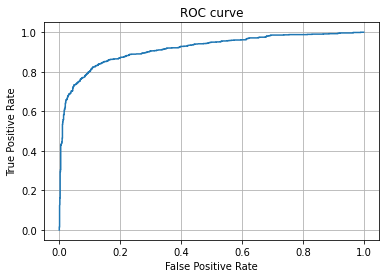

In [22]:
plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.title('ROC curve');

## Precision, Recall Curve

In [23]:
precision, recall, threshold = precision_recall_curve(val_labels_np, val_preds_np)

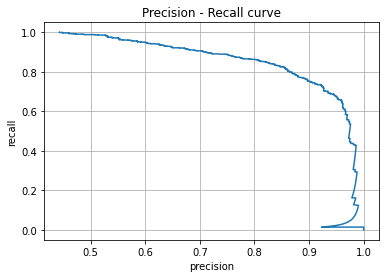

In [24]:
plt.plot(precision, recall)
plt.ylabel('recall')
plt.xlabel('precision')
plt.grid()
plt.title('Precision - Recall curve');

In [41]:
for pre, rec, thr in zip(precision, recall, threshold):
    if (pre >= 0.85) & (rec >= 0.8):
        print(pre, rec, thr)

0.8501228501228502 0.8247914183551848 0.4363273
0.8511685116851169 0.8247914183551848 0.43878654
0.8522167487684729 0.8247914183551848 0.44312268
0.8532675709001233 0.8247914183551848 0.4434699
0.8530864197530864 0.8235995232419547 0.44648018
0.8541409147095179 0.8235995232419547 0.44740275
0.8551980198019802 0.8235995232419547 0.44954577
0.8550185873605948 0.8224076281287247 0.45023832
0.8548387096774194 0.8212157330154947 0.45170912
0.8546583850931677 0.8200238379022646 0.45172915
0.8557213930348259 0.8200238379022646 0.45317623
0.8567870485678705 0.8200238379022646 0.45343098
0.8566084788029925 0.8188319427890346 0.45578858
0.8564294631710362 0.8176400476758046 0.4564025
0.85625 0.8164481525625745 0.45705867
0.8573216520650814 0.8164481525625745 0.45774105
0.8571428571428571 0.8152562574493445 0.45836213
0.8582183186951067 0.8152562574493445 0.45846727
0.8580402010050251 0.8140643623361145 0.4602271
0.8578616352201258 0.8128724672228844 0.46153846
0.8589420654911839 0.81287246722288

In [42]:
val_preds_m = np.where(val_preds_np>=0.4363273, 1, 0)

In [43]:
acc_m = accuracy_score(val_labels_np, val_preds_m)
f1_m = f1_score(val_labels_np, val_preds_m)

In [44]:
acc_m, f1_m

(0.8587184873949579, 0.837265577737447)